# 多模态RAG实战


多模态数据相较于传统 RAG 更具有挑战性，数据中包含文本、表格与图片。主要有三种处理方式：

- 一、基于多模态嵌入模型：成本较低，基于向量检索（依赖嵌入模型）
  - 使用多模态嵌入（如 OpenAI CLIP、阿里multimodal-embedding-v1）对图像和文本进行嵌入处理
  - 通过相似度搜索来检索图像和文本两者
  - 将原始图像和文本块输入到多模态大模型中，以进行答案合成

- 二、基于多模态大模型：成本适中，基于图片摘要检索（依赖大模型的图像理解能力）
  - 使用多模态大模型（如 GPT-4V）从图像生成文本摘要
  - 对文本进行嵌入处理并检索
  - 将文本块输入到一个大模型中进行答案合成

- 三、基于多模态大模型：速度慢、成本高，基于图片摘要检索，生成时再次结合问题重新理解图片
  - 使用多模态大模型（如 GPT-4V）从图像生成文本摘要
  - 对图像摘要进行嵌入处理并检索，同时保留对原始图像的引用
  - 将原始图像和文本块输入到多模态大模型中进行答案合成

  <img src="img/多模态-大模型.png">


In [51]:
from dotenv import load_dotenv
import os
import shutil

# 加载环境配置文件
_ = load_dotenv()

# 请将此路径替换为你的目录
BASE_DIR  = "F:\\AI\\L2\\Advanced-RAG\\source"

#资源地址
RESOURCE_DIR = BASE_DIR+ '\\resources'

# 工具地址
TOOLS_DIR = BASE_DIR + '\\tools'


#图片提取地址
IMAGE_OUT_DIR = RESOURCE_DIR + '\\images'


#pdf 地址
PDF_PATH = RESOURCE_DIR + "\\978-7-5170-2271-8_1.pdf"


RESIZE_IMAGE_DIR = RESOURCE_DIR+"\\temp"



## 第一种：基于多模态向量模型

  - 使用多模态嵌入（如 OpenAI CLIP、阿里multimodal-embedding-v1）对图像和文本进行嵌入处理
  - 通过相似度搜索来检索图像和文本两者
  - 将原始图像和文本块输入到多模态大模型中，以进行答案合成

### 一、PDF加载

使用非结构化的 `partition_pdf` 从 PDF 中提取元素。也可以尝试商业 PDF 解析工具，如：
- 阿里智能文档解析：https://www.aliyun.com/product/ai/docmind?spm=5176.28197619.console-base_help.2.2f051ad8cK2J1X
- 百度文档解析： https://cloud.baidu.com/doc/OCR/s/Klxag8wiy
- 字节火山文档解析：https://www.volcengine.com/docs/6790/1336102
- TextIn：https://www.textin.com/document/pdf_to_markdown?from=textin-Bintsig-baidusem-PC-wdjx-C55-hrv8g1kjez-yg

或者使用文档转换工具，将PDF转换为Markdown、Word处理。

依赖安装：
- Windows
  - 首次运行需要科学上网
  - 安装用于 PDF 渲染和处理的 poppler（处理PDF文件的工具）
    - 下载地址：https://github.com/oschwartz10612/poppler-windows/releases/download/v24.08.0-0/Release-24.08.0-0.zip
    - 导入方式：解压缩后将bin文件目录路径加入 系统‘Path’变量
  - 安装用于OCR（光学字符识别）的tesseract
    - 下载地址：https://github.com/tesseract-ocr/tesseract/releases/download/5.5.0/tesseract-ocr-w64-setup-5.5.0.20241111.exe
    - 导入方式：下载安装后，将安装路径加入 系统‘Path’变量
    > 以上工具已经提供在课件

- Mac
  - brew install poppler tesseract

- Linux
  - Debain系列（Ubuntu）：apt install poppler-utils tesseract-ocr
  - RedHat系列（CentOs）：yum install poppler-utils tesseract-ocr



In [ ]:
'''
如果没有配置系统环境变量，可以通过代码配置临时变量。
但是如果是打开cursor后配置的系统环境变量，配置完后需要重启cursor
'''

os.environ['path'] += os.pathsep + os.path.join(TOOLS_DIR,'poppler-24.08.0/Library/bin') 

!pdfinfo -v # pdfinfo version 24.08.0

pdfinfo version 24.08.0
Copyright 2005-2024 The Poppler Developers - http://poppler.freedesktop.org
Copyright 1996-2011, 2022 Glyph & Cog, LLC


In [ ]:
'''
如果没有配置系统环境变量，可以通过代码配置临时变量。
但是如果是打开cursor后配置的系统环境变量，配置完后需要重启cursor
'''

os.environ['path'] += os.pathsep + os.path.join(TOOLS_DIR,'Tesseract-OCR')

!tesseract -v # tesseract v5.5.0.20241111

tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


read_params_file: Can't open v5.5.0.20241111
Error, cannot read input file #: No such file or directory
Error during processing.


使用unstructured库解析PDF文档会下载模型与nltk数据包

一、模型：
1. 模型从huggingface下载，所以需要科学上网
配置临时环境变量（不需要重启Cursor）：
```
os.environ["http_proxy"] = "http://127.0.0.1:1080"
os.environ["https_proxy"] = "http://127.0.0.1:1080"
```
或者也可以配置到系统环境变量中，如果是打开cursor后配置的系统环境变量，配置完后需要**重启cursor**

2. 也可以配置huggingface镜像代理，就不用科学上网了,配置临时环境变量：（不需要重启Cursor）
```
os.environ['HF_ENDPOINT']='https://hf-mirror.com'
```
对于这个临时变量，注意：**一定要写到 import partition_pdf 前面，否则不生效**。</br>
或者配置到系统环境变量中，如果是打开cursor后配置的系统环境变量，配置完后需要**重启cursor**

二、nltkdata：</br>
nltkdata的下载地址无法访问：https://utic-public-cf.s3.amazonaws.com/nltk_data_3.8.2.tar.gz </br>
查看源码：`venv\Lib\site-packages\unstructured\nlp\tokenize.py` </br>
可知，需要 averaged_perceptron_tagger_eng 与 punkt_tab两个数据包 </br>
此时，可以手动下载：https://github.com/nltk/nltk_data/tree/gh-pages/packages </br>
下载后的存放路径可以运行以下代码查看：
```
import nltk
print(nltk.data.path)
```
只要存放到打印的任意一个地址即可。如：C:\Users\Administrator\AppData\Roaming\nltk_data
在该目录下新建：taggers与tokenizers两个文件夹，将averaged_perceptron_tagger_eng压缩包放入taggers中并解压，punkt_tab放入tokenizers中并解压。


In [59]:
import  os

from unstructured.partition.pdf import partition_pdf



# 如果图片提取目录存在则删除重建
if os.path.exists(IMAGE_OUT_DIR):
     shutil.rmtree(IMAGE_OUT_DIR)
os.makedirs(IMAGE_OUT_DIR)

pdf_data = partition_pdf(
    filename=PDF_PATH,
    extract_images_in_pdf=True, #提取图片
    infer_table_structure=True,    # 启用表格结构识别
    max_characters=4000,          # 每个文本块最大字符数
    new_after_n_chars=3800,       # 达到3800字符后分新块
    combine_text_under_n_chars=2000, # 合并小于2000字符的文本块
    chunking_strategy = "by_title", # 按标题分块
    extract_image_block_output_dir=IMAGE_OUT_DIR, #图片提取路径
)


In [60]:
print(pdf_data)#  ===> 【CompositeElement ，table，CompositeElement ，table】
print("="*100)
print(pdf_data[0].metadata.orig_elements) # 查看 CompositeElement （子节点）

print("="*100)
print(pdf_data[0].metadata.orig_elements[1]) # 查看 CompositeElement 的子节点


[<unstructured.documents.elements.CompositeElement object at 0x000001A0A580AB50>, <unstructured.documents.elements.CompositeElement object at 0x000001A0A5809550>, <unstructured.documents.elements.CompositeElement object at 0x000001A0A5B5AF50>, <unstructured.documents.elements.Table object at 0x000001A0A5967650>, <unstructured.documents.elements.CompositeElement object at 0x000001A0A5B590D0>, <unstructured.documents.elements.Table object at 0x000001A0A5B12E50>, <unstructured.documents.elements.CompositeElement object at 0x000001A014B8A750>, <unstructured.documents.elements.Table object at 0x000001A0870F8190>, <unstructured.documents.elements.CompositeElement object at 0x000001A021342690>, <unstructured.documents.elements.CompositeElement object at 0x000001A01180C610>, <unstructured.documents.elements.CompositeElement object at 0x000001A01498EF90>, <unstructured.documents.elements.CompositeElement object at 0x000001A011D42750>, <unstructured.documents.elements.CompositeElement object at 

### 二、提取表格与文本

In [56]:
from unstructured.documents.elements import Table,CompositeElement

tables = []
texts = []

for element in pdf_data:
    if isinstance(element,Table):
        tables.append(str(element))
    elif isinstance(element,CompositeElement):
        texts.append(str(element))

In [57]:
print(f"表格元素：{len(tables)} \n文本元素：{len(texts)}")

表格元素：4 
文本元素：14


### 三、多模态嵌入模型

In [67]:
# 如果使用OpenAI的Clip模型，需要安装依赖：
# pip install langchain-experimental open_clip_torch torch -i https://pypi.tuna.tsinghua.edu.cn/simple
from langchain_experimental.open_clip import OpenCLIPEmbeddings
# OpenCLIPEmbeddings()

# langchain中暂无其他多模态嵌入的实现，实现自己的阿里多模态嵌入
# https://bailian.console.aliyun.com/?tab=api#/api/?type=model&url=https%3A%2F%2Fhelp.aliyun.com%2Fdocument_detail%2F2712517.html&renderType=iframe
from typing import List

from langchain_community.embeddings.dashscope import DashScopeEmbeddings
from langchain_core.embeddings import Embeddings
from pydantic import BaseModel
import dashscope


class MultiDashScopeEmbeddings(BaseModel, Embeddings):

    '''多模态嵌入模型'''
    model: str = "multimodal-embedding-v1"

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        text_features = []
        for text in texts:
            resp = dashscope.MultiModalEmbedding.call(
                model=self.model,
                input= [{'text': text}]
            )
            embeddings_list = resp.output['embeddings'][0]['embedding']
            text_features.append(embeddings_list)
        return text_features

    def embed_query(self, text: str) -> List[float]:
        resp = dashscope.MultiModalEmbedding.call(
            model=self.model,
            input= [{'text': text}]
        )
        embeddings_list = resp.output['embeddings'][0]['embedding']
        return embeddings_list
    
    def embed_image(self, uris: List[str]) -> List[List[float]]:
        image_features = []
        for uri in uris:
            # 阿里dashscope SDK要求传递图片的地址，对于本地图片dashscope SDK会将图片上传到OSS服务中：
            local_image_uri = f"file://{uri}"
            resp = dashscope.MultiModalEmbedding.call(
                model=self.model,
                input=[{"image":local_image_uri}]
            )
            embeddings_list = resp.output['embeddings'][0]['embedding']
            print(f"{uri} 图片向量 {resp.status_code}：{embeddings_list[:3]}")
            image_features.append(embeddings_list)
        return image_features


### 四、嵌入图片与文本

In [68]:
import os
from langchain_chroma import Chroma

from langchain_core.documents import Document



vectorstore = Chroma(
    collection_name="multi-vector", 
    # persist_directory=r"F:\AI\L2\Advanced-RAG\source\db", # 持久化存储路径
    embedding_function= MultiDashScopeEmbeddings()
)



# 获得图片的地址
image_uris = sorted(
    [
        os.path.join(IMAGE_OUT_DIR, image_name)
        for image_name in os.listdir(IMAGE_OUT_DIR)
        if image_name.endswith(".jpg")
    ]
)

# 添加图片 （存储图像base64数据与其向量数据） 
vectorstore.add_images(uris=image_uris)    # embedding_function 向量化


# 添加文本与表格
vectorstore.add_documents([Document(page_content=table) for table in tables])  # embedding_function 向量化
vectorstore.add_documents([Document(page_content=text) for text in texts])

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})


F:\AI\L2\Advanced-RAG\source\resources\images\figure-1-1.jpg 图片向量 200：[0.01968494802713394, 0.0076696802861988544, 0.015384509228169918]
F:\AI\L2\Advanced-RAG\source\resources\images\figure-12-9.jpg 图片向量 200：[0.01522250659763813, 0.016220515593886375, 0.001269020140171051]
F:\AI\L2\Advanced-RAG\source\resources\images\figure-13-10.jpg 图片向量 200：[0.015502599067986012, 0.013917888514697552, -0.0016622231341898441]
F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-11.jpg 图片向量 200：[0.01621624268591404, 0.027511198073625565, -0.012939385138452053]
F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-12.jpg 图片向量 200：[-0.01880875788629055, -0.01028158888220787, -0.01987963728606701]
F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-13.jpg 图片向量 200：[0.01486346498131752, 0.01415680255740881, -0.009928605519235134]
F:\AI\L2\Advanced-RAG\source\resources\images\figure-18-14.jpg 图片向量 200：[0.012821930460631847, 0.01046158466488123, -0.007400982081890106]
F:\AI\L2\Advanced-RAG\source\r

In [69]:
retriever.invoke("手电筒电路图")

[Document(id='541cc019-c38a-4196-aed8-58873138a176', metadata={}, page_content='元件\n\n元件'),
 Document(id='50c7a333-780b-4ecc-bbac-f8f6f90b2d68', metadata={}, page_content='4A a 6A d c 4A a 6A d c a 6A 20 5 20 5 20 5 + + + + + + 140V - 6 10A 90V - 140V - 6 b 10A 90V - 140V - 6 10A 90V - b b （a）原电路 （b）选 b 点为参考点 （c）选 d 点为参考点 图 1.30 电位计算示例 d'),
 Document(id='20ae128b-2688-49e2-a08f-218a321f9e47', metadata={}, page_content='I=2A I[=-2A I=-2A Ta | a Tol ° A oO ° B O ° Cc o + U=5V + U=5SV + U=5V (a) (b) Co)'),
 Document(id='4c916d1b-46fd-43c4-87c0-1cb15bfb02aa', metadata={}, page_content='（a）关联参考方向 （b）非关联参考方向'),
 Document(id='50ebbbff-f75a-4ea0-b6b8-81096ce4073f', metadata={}, page_content='a b a + u - u （a） （b）'),
 Document(id='8e8ff85b-9eab-4f9d-bed9-ec760d3c6420', metadata={}, page_content='N U\n\n（1）电源的额定电流 IN；\n\n（2）电源的开路电压 UOC；\n\n（3）电源在额定工作情况下的负载电阻 RN；\n\n（4）负载发生短路时的短路电流 ISC。\n\nI\n\n   +      U      -         S1   A      S2   M      R0     +   US     -   +      U      -   S   R   图 1.

### 五、RAG构建

In [74]:
### 五、RAG构建
import io
from PIL import Image
import uuid 
import base64
import os


if os.path.exists(RESIZE_IMAGE_DIR):
    shutil.rmtree(RESIZE_IMAGE_DIR)
os.makedirs(RESIZE_IMAGE_DIR)

'''
缩放图片

注意：如果是OpenAI需要传递图片base64：
    {"type": "text","text":"需求" }
    {"type": "image_url","image_url":{"url":f"data:image/jpeg:base64,{base64_image_data}"} }
而ChatTongyi是对阿里DashScope SDK的封装，既可以传递图片的base64
https://bailian.console.aliyun.com/?tab=doc#/api/?type=model&url=https%3A%2F%2Fhelp.aliyun.com%2Fdocument_detail%2F2845871.html
    {"text": "需求"},{"image":f"data:image/jpeg:base64,{base64_image_data}"}}

也可以传递图片的地址，如果传递本地图片地址，阿里SDK会将图片上传到OSS服务中：
    {"text": "需求"},{"image":f"file://{图片的绝对地址}"}  
'''
def resize_base64_image4tongyi(base64_string, max_size=(640, 480)):
    # 解析图片
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    width, height = img.size
    ratio = max(max_size[0] / width, max_size[1] / height)
     # 计算按比例缩放后的宽高
    new_width = int(width * ratio)
    new_height = int(height * ratio)

    # 缩放
    resized_img = img.resize((new_width,new_height), Image.LANCZOS)

    # 保存图片到指定路径
    out_path = os.path.join(RESIZE_IMAGE_DIR,str(uuid.uuid4())+ ".jpg")
    resized_img.save(out_path)
    # 图片地址
    return out_path


"""检查是否为base64数据：图片"""
def is_base64(s):
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """缩放图片（防止图片过大，超过多模态大模型的窗口限制）"""
    images = []
    text = []
    for doc in docs:
        content = doc.page_content 
        if is_base64(content):
            # 缩放图片
            resize_image = resize_base64_image4tongyi(content)
            images.append(resize_image) 
        else:
            text.append(content)
    return {"images": images, "texts": text}

In [75]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_community.chat_models.tongyi import ChatTongyi


def prompt_func(data_dict):
    # "context":{"images": ["缩放后的图片地址","缩放后的图片地址"], "texts": "doc1"}
    # 提取图片与文本
    images = data_dict["context"]["images"]
    texts = data_dict["context"]["texts"]

    messages = []
    # 装载图片数据
    for image in images:
        messages.append(
            HumanMessage(
                content=[
                    {"text":f"请将图片标记标注为：`{image}`"}, 
                    {"image":f"file://{image}"}
                ]
            )
        )
    
     # 装载文本数据
    formatted_texts = "\n\n".join(texts)


    # 该提示词可优化，如加入少量样本，让大模型输出更稳定
    messages.append(
        HumanMessage(content=[
                {
                    "text": 
                    "你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。"
                    "你将获得相关的图片与文本作为参考的上下文。这些图片和文本都是根据用户输入的关键词从向量数据库中检索获取的。"
                    "请根据提供的图片和文本结合你丰富的知识与分析能力，提供一份全面的问题解答。"
                    "请将提供的图片标记自然融入答案阐述的对应位置进行合理排版，答案中提及的图片统一以`<image>传递的图片真实标记</image>`的形式呈现。\n\n"
                    f"用户的问题是：{data_dict['question']}\n\n"
                    "参考的文本或者表格数据：\n"
                    f"{formatted_texts}"
                }
            ]
        )
    )
    return messages


# 千问视觉模型（多模态）
llm = ChatTongyi(model="qwen-vl-max") 
# 可以传base64数据，可以传图片url地址，也可以传图片本地路径

# RAG pipeline
chain = (
    {
        "question": RunnablePassthrough(),
        "context": retriever | RunnableLambda(split_image_text_types)
    }
    | RunnableLambda(prompt_func)
    | llm
    | StrOutputParser()
)

In [92]:
retriever.invoke("手电筒的电路模型")

[Document(id='50c7a333-780b-4ecc-bbac-f8f6f90b2d68', metadata={}, page_content='4A a 6A d c 4A a 6A d c a 6A 20 5 20 5 20 5 + + + + + + 140V - 6 10A 90V - 140V - 6 b 10A 90V - 140V - 6 10A 90V - b b （a）原电路 （b）选 b 点为参考点 （c）选 d 点为参考点 图 1.30 电位计算示例 d'),
 Document(id='541cc019-c38a-4196-aed8-58873138a176', metadata={}, page_content='元件\n\n元件'),
 Document(id='20ae128b-2688-49e2-a08f-218a321f9e47', metadata={}, page_content='I=2A I[=-2A I=-2A Ta | a Tol ° A oO ° B O ° Cc o + U=5V + U=5SV + U=5V (a) (b) Co)'),
 Document(id='4c916d1b-46fd-43c4-87c0-1cb15bfb02aa', metadata={}, page_content='（a）关联参考方向 （b）非关联参考方向'),
 Document(id='50ebbbff-f75a-4ea0-b6b8-81096ce4073f', metadata={}, page_content='a b a + u - u （a） （b）'),
 Document(id='6adf4e5f-81b2-4a33-a531-cb14c7e76f6a', metadata={}, page_content='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMj

In [ ]:
chain = (
    {
        "question": RunnablePassthrough(),
        "context": retriever | RunnableLambda(split_image_text_types)   # "context":{"images": ["图片地址","图片地址"], "texts": "doc1"}
    }| RunnableLambda(prompt_func)
)

chain.invoke("手电筒的电路模型")

[HumanMessage(content=[{'text': '请将图片标记标注为：`F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\24cfa5f8-2fea-4cdd-abd2-42dc5cef8c41.jpg`'}, {'image': 'file://F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\24cfa5f8-2fea-4cdd-abd2-42dc5cef8c41.jpg'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'text': '请将图片标记标注为：`F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\a8af1a00-c8f7-4805-b5eb-b22a2615ad52.jpg`'}, {'image': 'file://F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\a8af1a00-c8f7-4805-b5eb-b22a2615ad52.jpg'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'text': '请将图片标记标注为：`F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\8f5eec23-52e4-4684-9c09-315bd62b599c.jpg`'}, {'image': 'file://F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\8f5eec23-52e4-4684-9c09-315bd62b599c.jpg'}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'text': '请将图片标记标注为：`F:\\AI\\L2\\Advanced-RAG\\source\\resources\\temp\\f9afeaf5

### 六、效果展示


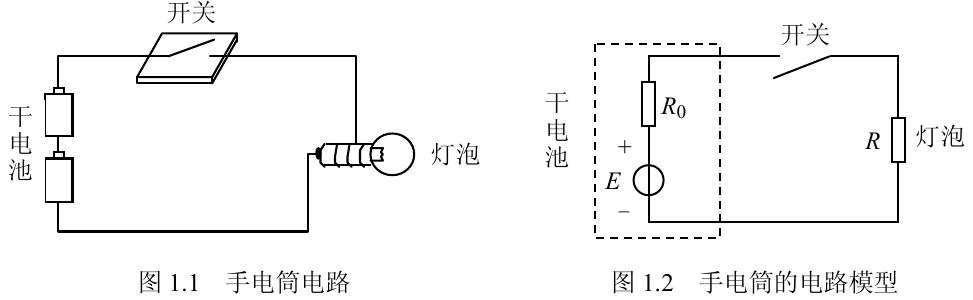


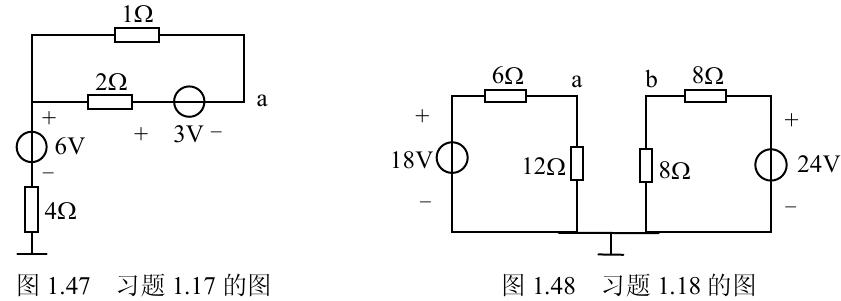


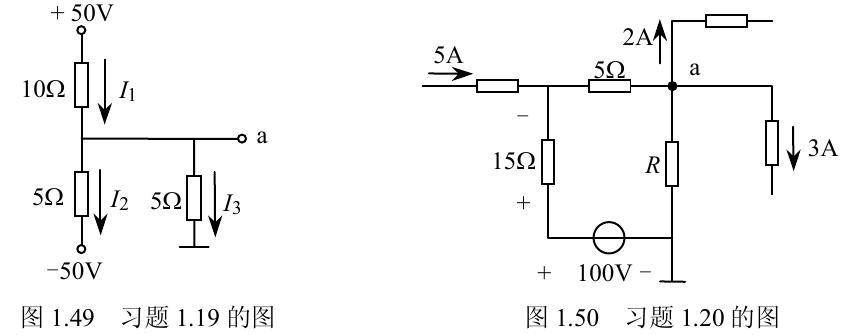


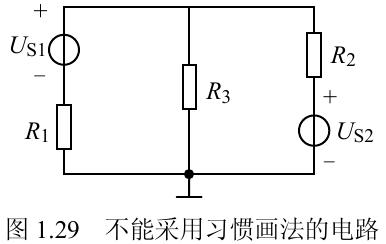


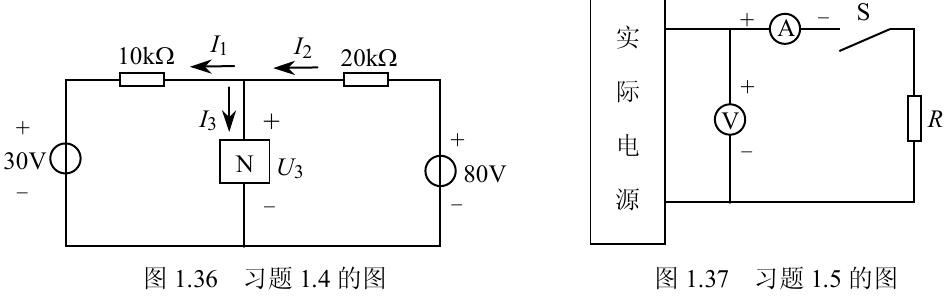

In [76]:
from IPython.display import HTML, display

#显示图片
def show_plt_img(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

query = "手电筒的电路模型"

docs = retriever.invoke(query)

for doc in docs:
    if is_base64(doc.page_content):
        # print(doc.page_content)
        show_plt_img(doc.page_content)

In [77]:
result = chain.invoke(query)

print(result)

手电筒的电路模型可以通过简化实际电路来表示，以便更好地理解和分析电路的工作原理。根据提供的图片，我们可以看到手电筒的实际电路和其对应的电路模型。

首先，我们来看一下手电筒的实际电路（图1.1）：<image>F:\AI\L2\Advanced-RAG\source\resources\temp\53cd2fa6-12a5-48a8-9c35-479e66d41cb5.jpg</image>。在这个电路中，主要包含以下几个元件：

1. 干电池：提供电源。
2. 开关：控制电路的通断。
3. 灯泡：作为负载，消耗电能并发光。

接下来，我们来看一下手电筒的电路模型（图1.2）：<image>F:\AI\L2\Advanced-RAG\source\resources\temp\53cd2fa6-12a5-48a8-9c35-479e66d41cb5.jpg</image>。在这个电路模型中，干电池被等效为一个电压源E和一个内阻R0的组合。灯泡则被等效为一个电阻R。

通过这个电路模型，我们可以更方便地进行电路分析。例如，我们可以使用欧姆定律计算电路中的电流和电压。假设干电池的电动势为E，内阻为R0，灯泡的电阻为R，则电路中的电流I可以表示为：

\[ I = \frac{E}{R_0 + R} \]

此外，我们还可以计算灯泡两端的电压U：

\[ U = I \cdot R = \frac{E \cdot R}{R_0 + R} \]

通过这些公式，我们可以对手电筒电路的工作状态进行定量分析。



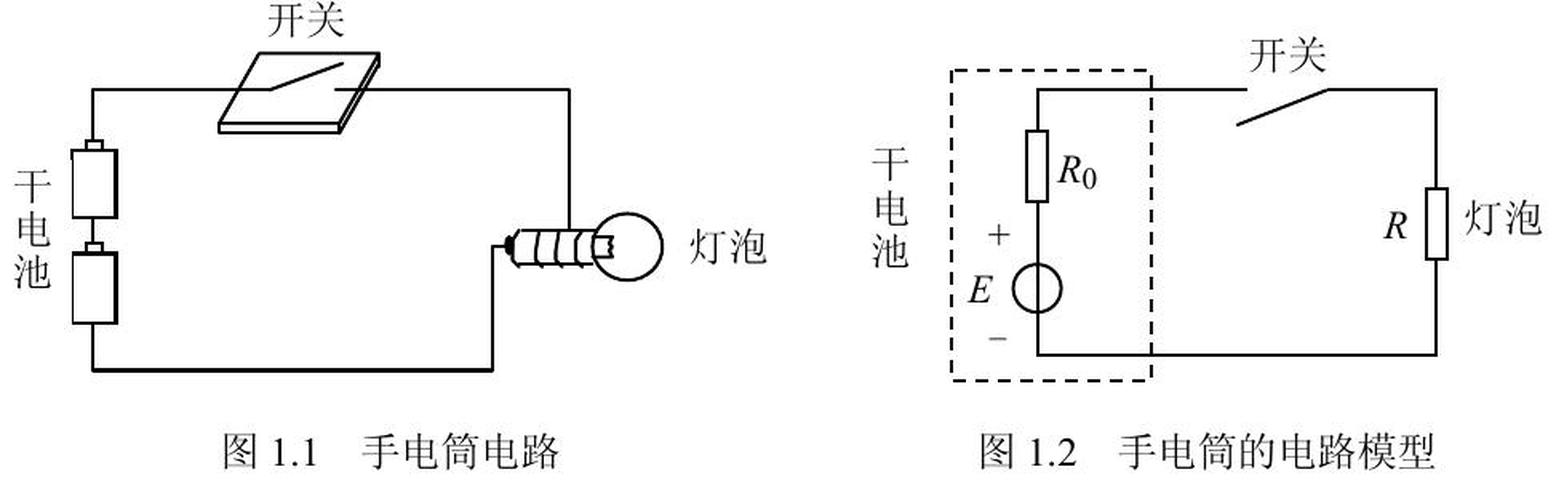


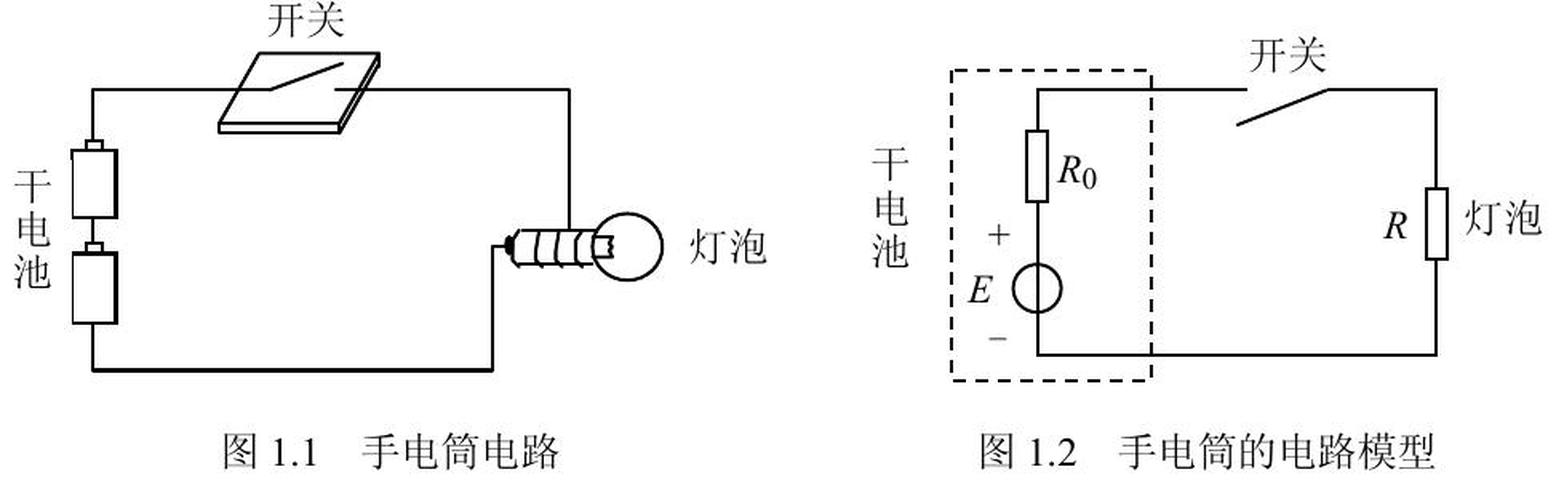

In [78]:
import base64
from IPython.display import HTML, display
import markdown

start_tag = "<image>"
end_tag = "</image>"


def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        img_data = img_file.read()
        img_base64 = base64.b64encode(img_data).decode('utf-8')
        return img_base64

def display_answer(text:str):
    # 根据<image>标签 分割文本：xxx<image>xxx</image> => ['xxx','xxx</image>'] 
    parts = text.split(start_tag)
    for part in parts:
        # 再根据</image>标签 分割文本：xxx => ['xxx'], xxx</image> => ['xxx','']
        chunks = part.split(end_tag)
        if len(chunks) > 1:
            # 存在图片
            image_path = chunks[0]
            context = chunks[1]
            img_base64 = encode_image(image_path)
            display(HTML(f'\n<img src="data:image/jpeg;base64,{img_base64}"/>\n'))
            display(HTML(markdown.markdown(context)))
        else:
            display(HTML(markdown.markdown(part)))

       
display_answer(result)

## 第三种：基于多模态大模型

  - 使用多模态大模型（如 GPT-4V）从图像生成文本摘要
  - 对图像摘要进行嵌入处理并检索，同时保留对原始图像的引用
  - 将原始图像和文本块输入到多模态大模型中进行答案合成

### 一、PDF加载
**与第一种一样，运行第一种中的对应代码**
### 二、提取表格和文本
**与第一种一样，运行第一种中的对应代码**

### 三、生成文本、表格摘要（接着第一种的一、二步后开始）

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.chat_models.tongyi import ChatTongyi

prompt = PromptTemplate.from_template(
    "你是一位负责生成表格和文本摘要以供检索的助理。"
    "这些摘要将被嵌入并用于检索原始文本或表格元素。"
    "请提供表格或文本的简明摘要，该摘要已针对检索进行了优化。表格或文本：{document}"
)

#使用大模型生成文本摘要
model = ChatTongyi(model="qwen-max")

summarize_chain = {"document": lambda x: x} | prompt | model | StrOutputParser()


text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### 四、生成图片摘要

In [16]:


def image_summarize(image_path):
    """生成图片摘要"""
    chat = ChatTongyi(model="qwen-vl-max")
    local_image_path = f"file://{image_path}"
    response = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"text" : "你是一名负责生成图像摘要以便检索的助理。这些摘要将被嵌入并用于检索原始图像。请生成针对检索进行了优化的简洁的图像摘要。"},
                    {"image": local_image_path}
                ]
            )
        ]
    )
    return response.content

# 检索图片摘要获得图片地址
img_list = []  #原图片地址
image_summaries = [] #图片摘要
for img_file in sorted(os.listdir(IMAGE_OUT_DIR)):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(IMAGE_OUT_DIR, img_file)
        img_list.append(img_path)
        # 生成图片摘要
        image_summaries.append(image_summarize(img_path)[0]["text"])

### 五、构建多向量检索（摘要索引）

In [17]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.embeddings.dashscope import DashScopeEmbeddings

embeddings_model = DashScopeEmbeddings(
    model="text-embedding-v1",
)

# 创建向量数据库（用于存储摘要）
vectorstore = Chroma(
    collection_name="multi_model", embedding_function=embeddings_model
)

# 创建内存存储（用于存储原内容）
docstore = InMemoryStore()

# 将摘要存储入库
id_key = "doc_id"
def add_documents( doc_summaries, doc_contents):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    vectorstore.add_documents(summary_docs)
    docstore.mset(list(zip(doc_ids, doc_contents)))

add_documents(text_summaries, texts)
add_documents(table_summaries, tables)
add_documents(image_summaries, img_list)

# 构建多向量检索（摘要索引）
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
    search_kwargs={"k": 7}
)

### 六、RAG构建

In [18]:
from pathlib import Path
from PIL import Image
import shutil
import os


if os.path.exists(RESIZE_IMAGE_DIR):
    shutil.rmtree(RESIZE_IMAGE_DIR)
os.makedirs(RESIZE_IMAGE_DIR)

''' 判断是否为图片地址 '''
def is_image_path(filepath):
    try:
        path = Path(filepath)
        return all([
            path.exists(),
            path.is_file(),
            path.suffix.lower() == '.jpg'
        ])
    except Exception:
        return False
    
def resize_base64_image4tongyi(image_path,  max_size=(640, 480)):
    try:
        # 打开图片
        img = Image.open(image_path)
        width, height = img.size
        ratio = min(max_size[0] / width, max_size[1] / height)
        # 计算按比例缩放后的宽高
        new_width = int(width * ratio)
        new_height = int(height * ratio)

        # 缩放
        resized_img = img.resize((new_width, new_height), Image.LANCZOS)
        # 保存图片到指定路径
        out_path = out_path = os.path.join(RESIZE_IMAGE_DIR,str(uuid.uuid4())+ ".jpg")
        resized_img.save(out_path)
        # 图片地址
        return out_path
    except Exception as e:
        print(f"处理图片时出错: {e}")
        return None


def split_image_text_types(docs):
    """
    拆分图像和文本
    """
    images = []
    texts = []
    # docs：文本内容和图片地址
    for doc in docs:
        if is_image_path(doc):
            doc = resize_base64_image4tongyi(doc)
            images.append(doc)
        else:
            texts.append(doc)
    return {"images": images, "texts": texts}

In [19]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models.tongyi import ChatTongyi

def img_prompt_func(data_dict):
    # 提取图片与文本
    images = data_dict["context"]["images"]
    texts = data_dict["context"]["texts"]

    messages = []
    # 装载图片数据
    for image in images:
        messages.append(
            HumanMessage(
                content=[
                    {"text":f"请将图片标记标注为：`{image}`"},
                    {"image":f"file://{image}"}
                ]
            )
        )
    # 装载文本数据
    formatted_texts = "\n\n".join(texts)
    messages.append(
        HumanMessage(content=[
            {
                "text": 
                "你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。"
                "你将获得相关的图片与文本作为参考的上下文。这些图片和文本都是根据用户输入的关键词从向量数据库中检索获取的。"
                "请根据提供的图片和文本结合你丰富的知识与分析能力，提供一份全面的问题解答。"
                "请将提供的图片标记自然融入答案阐述的对应位置进行合理排版，答案中提及的图片统一以`<image>传递的图片真实标记</image>`的形式呈现。\n\n"
                f"用户的问题是：{data_dict['question']}\n\n"
                "参考的文本或者表格数据：\n"
                f"{formatted_texts}"
                }
            ]
        )
    )
    
    return messages

# 千问视觉模型（多模态）
llm = ChatTongyi(model="qwen-vl-max")

# RAG pipeline
chain = (
    {
        "question": RunnablePassthrough(),
        "context": retriever | RunnableLambda(split_image_text_types)
    }
    | RunnableLambda(prompt_func)
    | llm
    | StrOutputParser()
)

### 七、效果展示

--------------- ['28653789-1e4d-4851-a2be-d310ea6889b4', 'ca6a5661-c7eb-4ae1-b678-97352789a9df', 'c574c687-eccb-4b85-8af3-51c8ae08c93e', 'f1d6a926-70c7-41a2-9cf3-73b2ebfcdbb1', 'c7f26f62-e9fc-411d-a837-1f00ef0e60b4', '0ad85750-8b99-44fe-b1c8-1644ed0f1bd0', 'a04fcffc-6c48-4973-b5c1-ed12fda71a90']



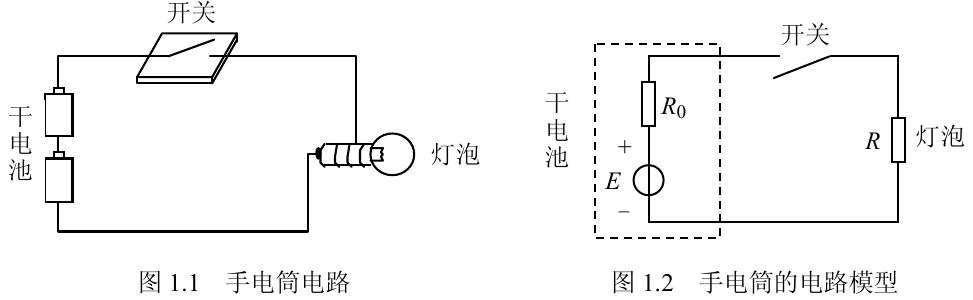


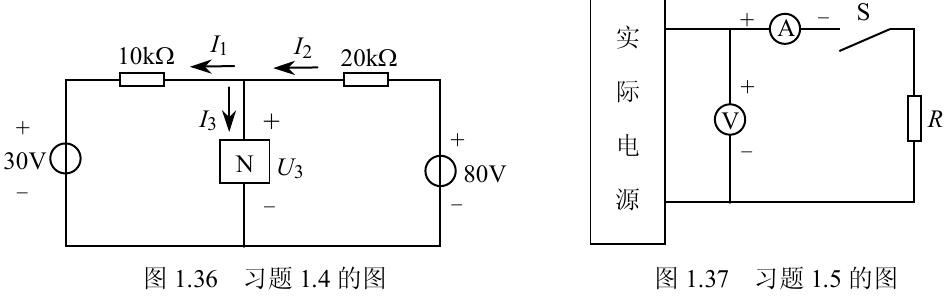


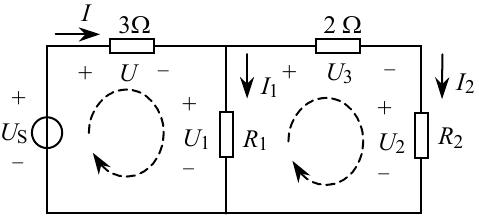


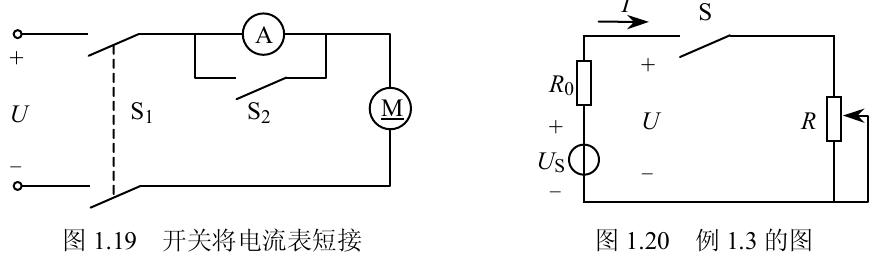


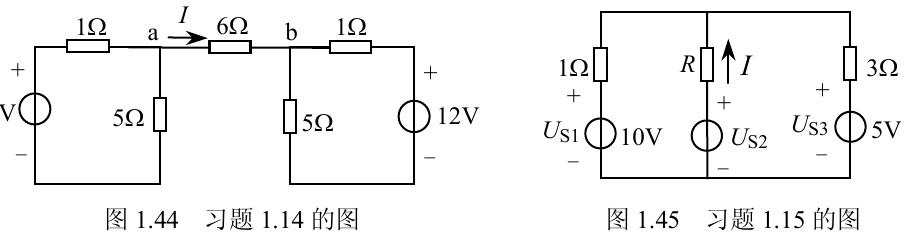


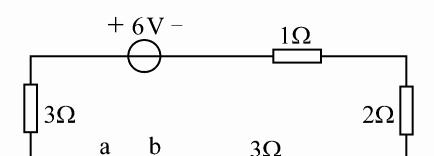


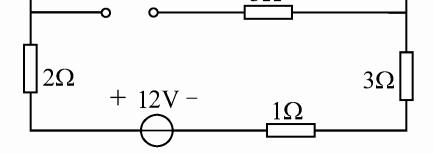

In [20]:
from IPython.display import HTML, display

#显示图片
def show_plt_img(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        img_data = img_file.read()
        img_base64 = base64.b64encode(img_data).decode('utf-8')
        return img_base64
    
query = "介绍下手电筒的电路模型"
# query = "导体中的电流方向是什么"

docs = retriever.invoke(query)
# 注意：这里检索出来的是图片地址或文本内容，而不是Document

for doc in docs:
    if is_image_path(doc):
        show_plt_img(encode_image(doc))

In [21]:
result = chain.invoke(query)

--------------- ['28653789-1e4d-4851-a2be-d310ea6889b4', 'ca6a5661-c7eb-4ae1-b678-97352789a9df', 'c574c687-eccb-4b85-8af3-51c8ae08c93e', 'f1d6a926-70c7-41a2-9cf3-73b2ebfcdbb1', 'c7f26f62-e9fc-411d-a837-1f00ef0e60b4', '0ad85750-8b99-44fe-b1c8-1644ed0f1bd0', 'a04fcffc-6c48-4973-b5c1-ed12fda71a90']



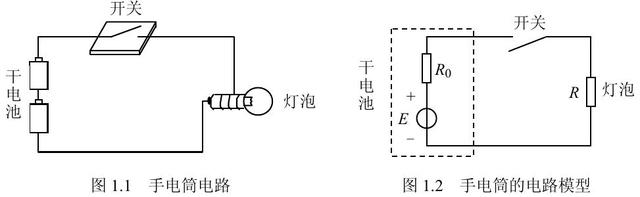

In [22]:
import base64
from IPython.display import HTML, display

start_tag = "<image>"
end_tag = "</image>"

def display_answer(text:str):
    # 根据<image>标签 分割文本：xxx<image>xxx</image> => ['xxx','xxx</image>'] 
    parts = text.split(start_tag)
    for part in parts:
        # 再根据</image>标签 分割文本：xxx => ['xxx'], xxx</image> => ['xxx','']
        chunks = part.split(end_tag)
        if len(chunks) > 1:
            # 存在图片
            image_path = chunks[0]
            context = chunks[1]
            img_base64 = encode_image(image_path)
            display(HTML(f'\n<img src="data:image/jpeg;base64,{img_base64}"/>\n'))
            # display(HTML(context.replace("\n", "<br/>")))
            display(HTML(markdown.markdown(context)))
        else:
            display(HTML(markdown.markdown(part)))
            # display(HTML(part.replace("\n", "<br/>")))  

       
display_answer(result)

# 优化：基于多模态大模型（成本与效果平衡）

## 优化目的
上文的实现，适合PDF中图片具备丰富信息，能单独理解的情况。
如果图片只用于展示或者需要文字辅助理解，即单独看图片不知道什么意思时，检索准确性一定不高！

- 基于多模态向量模型：
  - 多模态向量模型提取图片特征。若图片只用于展示或者需要文字辅助理解，即单独看图片不知道什么意思时，无法给与图片更多信息。因为图片单独无法理解，提取特征后（向量后）也一样。
- 基于多模态大模型：
  - 多模态大语言模型生成图片摘要。同样基于图片摘要检索时，若图片摘要生成结果不佳，检索准确率也不会高。

## 优化方案
基于多模态大模型来完成优化。利用通用文本大模型对文档文字内容生成摘要，基于文档摘要检索。
同时由多模态大模型生成图片摘要，在生成问题答案时，将图片摘要融入文档对应位置，最后答案由文本通用大模型来回答。既能获得比较好的效果，同时成本也不会像第三种方案那么高！
思路：
1. 解析PDF文档，解析的元素结果中存在元数据：`metadata.orig_elements` 该数据为list列表，列表中的内容为：哪些元素合并的当前元素。
2. 建立文本数据的摘要索引。图片只生成摘要，用于检索到文档后，融合进入文档对应位置：
<br>
`[Title][Table]...[Image] -> [文本][文本]...[<image src="图片地址">图片摘要</image>]`
<br>
3. 通过通用文本大模型完成解答，并在提示词中说明需要在返回的答案中包含答案参考的文档中对应图片的地址：<br> `<image src="图片地址"></image>`

<h3>最终提示词大概是：</h3>

*你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。你将获得相关文档作为参考的上下文。这些文档都是根据用户输入的关键词从向量数据库中检索获取的。请根据提供的文档结合你丰富的知识与分析能力，提供一份全面的问题解答。请将提供的文档中的图片`<image src='...'></image>`(不包括图片标签包围的文字)，自然融入答案阐述的对应位置进行合理排版。*

*用户的问题是：电流的方向是什么*

*参考的文本或者表格数据：<br>*
*文本数据...<br>*
*文本数据...\<image src="image1_path">图片1摘要<\/image><br>*
*文本数据...\<image src="image2_path">图片2摘要<\/image>文本数据...<br>*
*...*




## 一、PDF加载

In [4]:
from unstructured.partition.pdf import partition_pdf
import os
import shutil

# 如果图片提取目录存在则删除重建
if os.path.exists(IMAGE_OUT_DIR):
     shutil.rmtree(IMAGE_OUT_DIR)
os.makedirs(IMAGE_OUT_DIR)



# 使用unstructured库解析PDF文档(需要科学上网)  
pdf_data = partition_pdf(
    filename=PDF_PATH,
    extract_images_in_pdf=True,  
    infer_table_structure=True,    # 启用表格结构识别
    max_characters=4000,          # 每个文本块最大字符数
    new_after_n_chars=3800,       # 达到3800字符后分新块
    combine_text_under_n_chars=2000, # 合并小于2000字符的文本块
    chunking_strategy = "by_title", # 按标题分块
    extract_image_block_output_dir=IMAGE_OUT_DIR, #图片提取路径
)

f:\AI\L2\Advanced-RAG\source\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the che

In [23]:
pdf_data

In [24]:
'''合并后的元素类型：Table,CompositeElement'''
# 哪些元素合并成当前元素
print(pdf_data[0].metadata.orig_elements)
# Image元素
image = pdf_data[0].metadata.orig_elements[1]

print(image.metadata.to_dict())
# 提取的图片元素会进行OCR识别，所以text属性会包含图片的文字信息
print("修改前：",image.text)
# 不需要ocr的识别结果，在后面生成图片摘要时，会通过多模态大模型生成图片摘要，记录在text属性中
image.text = "图片摘要"
print("修改后：",image.text)

[<unstructured.documents.elements.Title object at 0x000001A014D5DB90>, <unstructured.documents.elements.Image object at 0x000001A014A13750>, <unstructured.documents.elements.ListItem object at 0x000001A01575A3D0>, <unstructured.documents.elements.ListItem object at 0x000001A01575ACD0>, <unstructured.documents.elements.ListItem object at 0x000001A015759AD0>, <unstructured.documents.elements.ListItem object at 0x000001A015758ED0>, <unstructured.documents.elements.ListItem object at 0x000001A01575AA10>, <unstructured.documents.elements.NarrativeText object at 0x000001A015759B10>, <unstructured.documents.elements.NarrativeText object at 0x000001A015759D10>, <unstructured.documents.elements.NarrativeText object at 0x000001A01575B150>, <unstructured.documents.elements.Title object at 0x000001A01575B510>, <unstructured.documents.elements.NarrativeText object at 0x000001A01575A390>, <unstructured.documents.elements.Text object at 0x000001A011D01150>, <unstructured.documents.elements.Header obj

## 二、生成摘要

In [25]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.chat_models.tongyi import ChatTongyi

prompt = PromptTemplate.from_template(
    "你是一位负责生成表格和文本摘要以供检索的助理。"
    "这些摘要将被嵌入并用于检索原始文本或表格元素。"
    "请提供表格或文本的简明摘要，该摘要已针对检索进行了优化。表格或文本：{document}"
)

#使用大模型生成文本摘要
model = ChatTongyi(model="qwen-max")

summarize_chain = {"document": lambda x: x.text} | prompt | model | StrOutputParser()

summaries = summarize_chain.batch(pdf_data, {"max_concurrency": 5})

In [26]:
from unstructured.documents.elements import Image as ImageElement
from langchain_core.messages import HumanMessage
from langchain_community.chat_models.tongyi import ChatTongyi

def image_summarize(image_path):
    """生成图片摘要"""
    chat = ChatTongyi(model="qwen-vl-max")
    local_image_path = f"file://{image_path}"
    print(f"生成摘要:{image_path}")
    response = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"text" : "你是一名负责生成图像摘要以便检索的助理。这些摘要将被嵌入并用于检索原始图像。请生成针对检索进行了优化的简洁的图像摘要。"},
                    {"image": local_image_path}
                ]
            )
        ]
    )
    return response.content

image_summaries = []
#image_list = []
for element in pdf_data:
    orig_elements = element.metadata.orig_elements
    length = len(orig_elements)
    for i, orig_element in enumerate(orig_elements):
        # 图片元素
        if isinstance(orig_element, ImageElement):
            image_path = orig_element.metadata.to_dict()["image_path"]
            #image_list.append(orig_element)
            # 将图片摘要记录在图片元素的text属性中
            summarizes = image_summarize(image_path)[0]["text"]
            orig_element.text = summarizes
            image_summaries.append(summarizes)

生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-1-1.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-3-2.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-4-3.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-5-4.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-7-5.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-8-6.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-9-7.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-9-8.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-12-9.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-13-10.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-11.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-12.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-13.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-18-14.jpg
生成摘要:F:\AI\L2\Advanced-RAG\source\resources\images\figure-19-15.j

In [27]:
print(image_summaries[0])
print(pdf_data[0].metadata.orig_elements[1].text)

这是一张显示放大镜和书页的图像，放大镜位于书页上方，似乎正在检查或强调书页上的内容。书页上有一些中文文字，可能是标题或标签，但具体内容无法从图像中直接读取。这种图像通常用于表示学习、研究或教育主题，暗示着对知识的探索或详细审查。
这是一张显示放大镜和书页的图像，放大镜位于书页上方，似乎正在检查或强调书页上的内容。书页上有一些中文文字，可能是标题或标签，但具体内容无法从图像中直接读取。这种图像通常用于表示学习、研究或教育主题，暗示着对知识的探索或详细审查。


## 三、构建索引

In [28]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.embeddings.dashscope import DashScopeEmbeddings

embeddings_model = DashScopeEmbeddings(
    model="text-embedding-v1",
)

# 创建向量数据库（用于存储摘要）
vectorstore = Chroma(
    collection_name="multi_model_opt", embedding_function=embeddings_model
)

# 创建内存存储（用于存储原内容）
docstore = InMemoryStore()

# 将摘要存储入库
id_key = "doc_id"
def add_documents( doc_summaries, doc_contents):
    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    vectorstore.add_documents(summary_docs)
    docstore.mset(list(zip(doc_ids, doc_contents)))

# 不再单独放入图片摘要
add_documents(summaries, pdf_data) #PDF Element

# 构建多向量检索（摘要索引）
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
    search_kwargs={"k": 2}
)

## 四、RAG构建

In [45]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models.tongyi import ChatTongyi
from unstructured.documents.elements import Image as ImageElement

def split_image_text_types(docs):
    texts = []
    # 注意：doc为PDF Element
    for doc in docs:
        text = ''
        # 获得所有子元素
        orig_element = doc.metadata.orig_elements
        for element in orig_element:
            # 是否为图片元素
            if isinstance(element, ImageElement):
                # 图片元素用标记包裹
                print("文档上下文中图片：",element.metadata.image_path)
                text += f'<image src="{element.metadata.image_path}">{element.text}</image>'
            else:
                # 其他元素直接放入文本
                text += element.text
        texts.append(text)
    return texts

def prompt_func(data_dict):
    question = data_dict["question"]
    context = data_dict["context"]
    # 装载数据
    formatted_texts = "\n\n".join(context)
   
    prompt = ("你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。"
    "你将获得相关文档作为参考的上下文。这些文档都是根据用户输入的关键词从向量数据库中检索获取的。"
    "请根据提供的文档结合你丰富的知识与分析能力，提供一份全面的问题解答。"
    r"请返回Markdown格式数据，并且当涉及到数学公式时，请使用正确的LaTeX语法来编写这些公式，对于行内公式应该以单个美元符号`$`;对于独立成行的公式，使用双美元符号`$$`包裹。例如，行内公式：`$a = \frac{1}{2}$`,而独立成行的公式则是：`$$ a = \frac{1}{2} $$`。"
    "请将提供的文档中的图片`<image src='...'>`(不包括`<image>`到`</image>`中间的文字)，在需要时自然融入答案阐述的对应位置进行合理排版。\n\n"
    f"用户的问题是：\n{question}\n\n"
    "参考的文本或者表格数据：\n"
    f"{formatted_texts}")
    print("="*150)
    print("完整提示词:\n",prompt)
    return prompt

# 文本通用大模型
llm = ChatTongyi(model="qwen-max")

# RAG pipeline
chain = (
    {
        "question": RunnablePassthrough(),
        # retriever：检索器搜索的结果为：PDF Element
        "context": retriever | RunnableLambda(split_image_text_types)  
    }
    | RunnableLambda(prompt_func)
    | llm
    | StrOutputParser()
)


## 五、效果展示

In [46]:
result = chain.invoke("介绍下电路模型")
# result = chain.invoke("电流的方向是什么")

result

--------------- ['c167ee40-165e-4a12-81ee-098d602995f3', '4be62763-38f2-4cba-88d9-a016bc003d74']
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-1-1.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-3-2.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-32-37.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-32-38.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-33-39.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-33-40.jpg
完整提示词:
 你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。你将获得相关文档作为参考的上下文。这些文档都是根据用户输入的关键词从向量数据库中检索获取的。请根据提供的文档结合你丰富的知识与分析能力，提供一份全面的问题解答。请返回Markdown格式数据，并且当涉及到数学公式时，请使用正确的LaTeX语法来编写这些公式，对于行内公式应该以单个美元符号`$`;对于独立成行的公式，使用双美元符号`$$`包裹。例如，行内公式：`$a = \frac{1}{2}$`,而独立成行的公式则是：`$$ a = \frac{1}{2} $$`。请将提供的文档中的图片`<image src='...'>`(不包括`<image>`到`</image>`中间的文字)，在需要时自然融入答案阐述的对应位置进行合理排版。

用户的问题是：
介绍下电路模型

参考的文本或者表格数据：
第 1 章 电路的基本概念和定律<image src="F:\AI\L2\Advanced-RAG\source\reso

'### 电路模型介绍\n\n在电气工程中，为了便于分析和理解实际电路的工作原理，通常会将复杂的实际电路简化为理想化的电路模型。这种模型化的方法不仅有助于理论研究，也是解决实际问题的基础。下面将详细介绍电路模型的概念、组成以及一些基本的电路元件。\n\n#### 1. 电路及其功能\n\n- **定义**：电路是为了某种需要而将某些电工设备或元件按一定方式组合起来所构成的电流通路。\n- **主要功能**：\n  - 能量转换、传输与分配：如电力系统将发电机发出的电能通过输电线传输到用电设备。\n  - 信号传递与处理：如扩音机电路中的信号放大和转换过程。\n\n#### 2. 电路的组成\n\n任何电路都至少包含三个基本组成部分：\n- **电源**：提供电能的设备，例如干电池、蓄电池等，负责将其他形式的能量转换成电能。\n- **负载**：消耗电能并将其转化为其他形式能量的装置，如灯泡（光能）、电动机（机械能）等。\n- **中间环节**：包括开关、导线等，用于连接电源与负载，并可能包含保护和测量装置。\n\n#### 3. 电路模型\n\n- **概念**：为了方便分析计算，实际电路被抽象化为由理想电路元件组成的电路模型。\n- **理想电路元件**主要包括：\n  - 无源元件（不产生能量）：电阻器、电感器、电容器。\n  - 有源元件（可以提供能量）：理想电压源、理想电流源。\n\n##### 实例说明\n考虑一个简单的手电筒电路示例：\n\n![手电筒电路](F:\\AI\\L2\\Advanced-RAG\\source\\resources\\images\\figure-3-2.jpg)\n\n- 图1.1展示了物理上的手电筒电路，其中包括两节干电池作为电源、一个灯泡作为负载，以及开关等中间环节。\n- 图1.2则是该手电筒对应的电路模型，其中使用了理想化的元件来表示：\n  - 干电池用理想电压源E加上内阻R0代替；\n  - 灯泡被视为纯电阻R；\n  - 开关及连接导线假设为理想的无电阻连接。\n\n#### 4. 电路模型的应用\n\n- 在进行电路设计时，工程师们首先会根据需求构建合适的电路模型。\n- 通过对这些模型的研究，可以预测实际电路的行为，从而优化设计方案。\n- 电路模型还广泛应用于教学领域，帮助学生更好地理解和掌握电路理论。

In [47]:
import base64
from IPython.display import HTML, display,Markdown

import re

def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        img_data = img_file.read()
        img_base64 = base64.b64encode(img_data).decode('utf-8')
        return img_base64

def display_answer(text:str):
    # 正则表达式：用于匹配 <image src="xxx"> 并捕获 src 属性的值
    pattern = r'(<image src="([^"]*)">)'
    # abc<image src="xxx">def -》 ["abc", "<image src="xxx">", "xxx", "def"] 
    chunks = re.split(pattern, text)
    for i, chunk in enumerate(chunks):
        # 文本内容
        if i % 3 == 0: 
            display(Markdown(chunk.replace("</image>", "")))
        elif i % 3 == 2:
            # image_path = re.search(r'src="([^"]*)"', chunk).group(1) 1% 3==1
            img_base64 = encode_image(chunk)
            display(HTML(f'\n<img src="data:image/jpeg;base64,{img_base64}"/>\n'))



def display_answer(text:str):
    display(Markdown(text.replace("F:\\AI\\L2\\Advanced-RAG\\source\\","")))


display_answer(result)



### 电路模型介绍

在电气工程中，为了便于分析和理解实际电路的工作原理，通常会将复杂的实际电路简化为理想化的电路模型。这种模型化的方法不仅有助于理论研究，也是解决实际问题的基础。下面将详细介绍电路模型的概念、组成以及一些基本的电路元件。

#### 1. 电路及其功能

- **定义**：电路是为了某种需要而将某些电工设备或元件按一定方式组合起来所构成的电流通路。
- **主要功能**：
  - 能量转换、传输与分配：如电力系统将发电机发出的电能通过输电线传输到用电设备。
  - 信号传递与处理：如扩音机电路中的信号放大和转换过程。

#### 2. 电路的组成

任何电路都至少包含三个基本组成部分：
- **电源**：提供电能的设备，例如干电池、蓄电池等，负责将其他形式的能量转换成电能。
- **负载**：消耗电能并将其转化为其他形式能量的装置，如灯泡（光能）、电动机（机械能）等。
- **中间环节**：包括开关、导线等，用于连接电源与负载，并可能包含保护和测量装置。

#### 3. 电路模型

- **概念**：为了方便分析计算，实际电路被抽象化为由理想电路元件组成的电路模型。
- **理想电路元件**主要包括：
  - 无源元件（不产生能量）：电阻器、电感器、电容器。
  - 有源元件（可以提供能量）：理想电压源、理想电流源。

##### 实例说明
考虑一个简单的手电筒电路示例：

![手电筒电路](resources\images\figure-3-2.jpg)

- 图1.1展示了物理上的手电筒电路，其中包括两节干电池作为电源、一个灯泡作为负载，以及开关等中间环节。
- 图1.2则是该手电筒对应的电路模型，其中使用了理想化的元件来表示：
  - 干电池用理想电压源E加上内阻R0代替；
  - 灯泡被视为纯电阻R；
  - 开关及连接导线假设为理想的无电阻连接。

#### 4. 电路模型的应用

- 在进行电路设计时，工程师们首先会根据需求构建合适的电路模型。
- 通过对这些模型的研究，可以预测实际电路的行为，从而优化设计方案。
- 电路模型还广泛应用于教学领域，帮助学生更好地理解和掌握电路理论。

总之，通过建立电路模型，我们能够更直观地分析复杂电路的工作机制，这对于深入学习电路理论和开展相关技术应用都是非常重要的。希望以上内容对你有所帮助！如果你有任何进一步的问题，请随时提问。

In [48]:
display_answer(chain.invoke("再详细介绍下什么是理想电压源"))

--------------- ['781e1ea3-01e5-40fb-92ff-9487645eafb8', '946a8637-7ac8-40e6-a487-3afa0f50ed4d']
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-13-10.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-11.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-12.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-13.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-12-9.jpg
完整提示词:
 你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。你将获得相关文档作为参考的上下文。这些文档都是根据用户输入的关键词从向量数据库中检索获取的。请根据提供的文档结合你丰富的知识与分析能力，提供一份全面的问题解答。请返回Markdown格式数据，并且当涉及到数学公式时，请使用正确的LaTeX语法来编写这些公式，对于行内公式应该以单个美元符号`$`;对于独立成行的公式，使用双美元符号`$$`包裹。例如，行内公式：`$a = \frac{1}{2}$`,而独立成行的公式则是：`$$ a = \frac{1}{2} $$`。请将提供的文档中的图片`<image src='...'>`(不包括`<image>`到`</image>`中间的文字)，在需要时自然融入答案阐述的对应位置进行合理排版。

用户的问题是：
再详细介绍下什么是理想电压源

参考的文本或者表格数据：
图 1.13 理想电压源恒压源不能短路，否则流过的电流为无限大。根据恒压源所连接的外电路，如果电流的实际方向由低电位端流向高电位端， 则恒压源发出功率，如图 1.13（a）所示。如果电流的实际方向由高电位端流向低第 1 章 电路的基本概念和定律电位

### 理想电压源的详细介绍

理想电压源是一种能够产生并维持一定输出电压的理想电源元件，也被称为恒压源。在电路理论中，理想电压源的概念对于理解和分析电路行为至关重要。

#### 1. 定义与特性
- **定义**：理想电压源是指无论通过它的电流如何变化，其两端的电压始终保持为一个固定值或确定的时间函数\(u_s\)。这意味着理想电压源的电压与其流过的电流无关。
- **符号表示**：理想电压源通常用特定的电路符号来表示，在图 1.13（a）中展示了一个理想电压源的示意图，其中 \(u_s\) 表示电压源的电压值。<image src="resources\images\figure-12-9.jpg">
- **伏安特性曲线**：如图 1.13(d) 所示，理想电压源的伏安特性曲线是一条水平直线，位于纵轴上的位置由电压源的具体电压值决定，表明无论通过的电流是多少，电压保持不变。$$ U = U_S $$

#### 2. 工作模式
- **作为电源供电**：当理想电压源向外部电路提供能量时，电流从正极流出，经过负载后回到负极，如图 1.13(a)所示。此时，电源对外做功，即发出功率。
- **作为负载吸收功率**：如果外加电压使得电流反向流动，即从负极流向正极，则该电压源将吸收外部提供的能量，扮演着负载的角色，如图 1.13(b)所示。这种情况类似于给电池充电的过程。

#### 3. 使用注意事项
- **不能短路**：理想电压源绝对不允许直接短路连接。因为一旦发生短路，理论上会形成无限大的电流，这不仅会造成极大的能量损失，还可能损坏电源本身及连接的其他设备。因此，在实际应用中必须确保有合适的负载存在。
- **实际模型对比**：现实中不存在完美的理想电压源，每个电源都有一定的内阻\(R_0\)。如图 1.15(a)所示，实际电压源可以看作是由一个理想电压源\(U_S\)串联一个内部电阻\(R_0\)组成的等效电路。这种情况下，电源输出端的实际电压\(U\)将小于理想电压\(U_S\)，差值取决于内阻上产生的压降\(IR_0\)。

综上所述，理想电压源是电路分析中的一个重要概念，它简化了对复杂系统的研究过程，但在具体设计和实现时需要考虑到实际存在的非理想因素。理解这些基本原理有助于更好地掌握电路工作机理，并指导相关工程实践。

In [49]:
result = chain.invoke("电流是什么")
print(result)

display_answer(result)

--------------- ['6583eee9-b19b-4939-aec2-eba1e21b565c', '781e1ea3-01e5-40fb-92ff-9487645eafb8']
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-4-3.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-5-4.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-13-10.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-11.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-12.jpg
文档上下文中图片： F:\AI\L2\Advanced-RAG\source\resources\images\figure-14-13.jpg
完整提示词:
 你是作为一名专业的电气工程师和电路理论专家。你的任务是用中文回答与电路基本概念和定律相关的问题。你将获得相关文档作为参考的上下文。这些文档都是根据用户输入的关键词从向量数据库中检索获取的。请根据提供的文档结合你丰富的知识与分析能力，提供一份全面的问题解答。请返回Markdown格式数据，并且当涉及到数学公式时，请使用正确的LaTeX语法来编写这些公式，对于行内公式应该以单个美元符号`$`;对于独立成行的公式，使用双美元符号`$$`包裹。例如，行内公式：`$a = \frac{1}{2}$`,而独立成行的公式则是：`$$ a = \frac{1}{2} $$`。请将提供的文档中的图片`<image src='...'>`(不包括`<image>`到`</image>`中间的文字)，在需要时自然融入答案阐述的对应位置进行合理排版。

用户的问题是：
电流是什么

参考的文本或者表格数据：
1.2 电路的基本物理量研究电路的基本规律，首先要掌握电路中的电流、电压和功率等基本物理量。1.2.1 电流电流是由电荷有规则

### 电流的概念及其特性

电流是由电荷有规则的定向运动形成的物理现象。它不仅描述了电荷流动的状态，还反映了电荷流动的强度。在数值上，电流等于单位时间内通过某一导体横截面的电量。数学表达式为：

$$
i = \frac{dq}{dt}
$$

其中：
- \( i \) 表示电流强度；
- \( dq \) 是在时间间隔 \( dt \) 内通过导体横截面的电量。

#### 直流与交流

- **直流 (DC)**：如果电流不随时间变化，即 \( \frac{dq}{dt} \) 为常数，则这种电流称为恒定电流或直流。直流电流用大写字母 \( I \) 表示。例如：
  $$
  I = \frac{q}{t}
  $$

- **交流 (AC)**：如果电流的大小和方向都随时间变化，则称为交变电流或交流。交流电流用小写字母 \( i \) 表示。

在国际单位制中，电流的基本单位是安培（A）。对于微小电流，常用毫安（mA）或微安（μA）作为单位，它们之间的换算关系为：
- 1 A = 10^3 mA
- 1 A = 10^6 μA

#### 电流的实际方向与参考方向

电流的实际方向是指电荷实际移动的方向。在简单的电路中，电流的实际方向容易判断；但在复杂电路中，电流的实际方向往往难以事先确定。因此，在分析电路时，通常先任意选定一个方向作为电流的**参考方向**，并用带方向的箭头标于电路图中。计算后根据结果的正负来确定电流的实际方向：
- 如果计算结果 \( I_x > 0 \)，则说明电流的实际方向与其参考方向一致。
- 如果计算结果 \( I_x < 0 \)，则说明电流的实际方向与其参考方向相反。

<image src="resources\images\figure-4-3.jpg">

如图1.3所示，导体中的电流标记为 \( I_{ab} \)，表示电流从a点流向b点。而图1.4是一个桥式电路图，包含电源 \( U_S \)、电阻 \( R_0, R_1, R_2, R_3, R_4 \) 和未知电阻 \( R_x \)，以及节点a和b。假设 \( I_x \) 的参考方向从a流向b，若求得 \( I_x > 0 \)，则实际方向与参考方向一致；反之亦然。

#### 电压与电动势

电压是衡量电场力做功能力的物理量，定义为电场力把单位正电荷从一点移动到另一点所做的功。其表达式为：

$$
u = \frac{dW}{dq}
$$

对于恒定电压或直流电压 \( U \)：

$$
U = \frac{W}{q}
$$

电压的单位是伏特（V），常用的还有千伏（kV）、毫伏（mV）和微伏（μV）等。

<image src="resources\images\figure-5-4.jpg">

图1.5展示了电压与电动势的关系，其中 \( u_{ab} \) 表示a点和b点之间的电压差。

#### 电流源与电压源

- **理想电压源**：能提供恒定电压的电源，但不能短路，否则会导致无限大的电流。
- **理想电流源**：能产生并维持一定输出电流的电源，但不能开路，否则两端电压将无限大。

<image src="resources\images\figure-13-10.jpg">

图1.13展示了理想电流源的不同工作状态及其伏安特性曲线。

综上所述，电流是电荷有规则的定向运动，可以通过其强度来衡量，并且在电路分析中，正确理解电流的实际方向与参考方向的选择至关重要。

In [89]:
from unstructured.documents.elements import Element


pdf_data2 = partition_pdf(
    filename=r"F:\AI\L2\Advanced-RAG\source\resources\MethodsPLCMOS12.pdf",
    infer_table_structure=True,    # 启用表格结构识别
    max_characters=4000,          # 每个文本块最大字符数
    new_after_n_chars=3800,       # 达到3800字符后分新块
    combine_text_under_n_chars=2000, # 合并小于2000字符的文本块
    chunking_strategy = "by_title", # 按标题分块
    # 如果表格是中文，需要下载语言包：https://github.com/tesseract-ocr/tessdata
    # 放入Tesseract安装目录下的tessdata文件夹
    languages=["chi_sim"]  
)

element = pdf_data2[0]
print(element.text)
print(pdf_data2[0].metadata.text_as_html)
display(HTML(pdf_data2[0].metadata.text_as_html))



2024年 100万营收 2025年 200万营收
<table><tr><td>2024 年</td><td>2025 年</td></tr><tr><td>100 万 营 收</td><td>200 万 营 收</td></tr></table>


2024 年,2025 年
100 万 营 收,200 万 营 收
